# **CANDEV -- STAT CAN DATA CHALLENGE**
## **Canadian Space Agency -  Forecasting Northern Lights **
**Participants : ** 
Bryan Paget, Amine Natik, Soufiane Fadel and Younes Driouiche.

## Importing useful libraries and packages


In [8]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans 
import cv2
import os.path
from skimage import data, io, filters, util
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## DATA AVAILABILITY: Deciding which data to use

In [41]:
!curl ftp://ftp.asc-csa.gc.ca/users/OpenData_DonneesOuvertes/pub/THEMIS/data_availability/themis_asi_data_availability.csv -o avail.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2910  100  2910    0     0   1659      0  0:00:01  0:00:01 --:--:--  1659


In [42]:
!curl ftp://ftp.asc-csa.gc.ca/users/OpenData_DonneesOuvertes/pub/THEMIS/data_availability/themis_gmag_data_availability.csv  -o avail2.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2768  100  2768    0     0   1728      0  0:00:01  0:00:01 --:--:--  1727


In [43]:
df = pd.read_csv("avail2.csv")
for index, row in df.iterrows():
    for i in range(2007,2018):
        if(row[str(i)] > 340 and index > 0):
            print(index," ",str(i))

4   2008
4   2013
19   2010
24   2007
24   2008
24   2009
24   2010
24   2011
24   2012
24   2013
24   2015
24   2016
24   2017
25   2007
25   2009
25   2010
25   2011
25   2012
25   2014
26   2007
26   2010
26   2013
26   2014
26   2016
26   2017
27   2010
27   2012
27   2013
27   2014
27   2015
27   2017
28   2007
28   2011
28   2012
28   2014
29   2012
29   2013
29   2014
29   2015
29   2017
31   2012
32   2009
32   2013
33   2007
33   2008
33   2010
33   2014
33   2015
33   2016


We will  choose for example the Dataset from the year 2010 because it has more observations.

## Preparing GMAG data:

In [44]:
!mkdir gmag_clean
!curl ftp://ftp.asc-csa.gc.ca/users/OpenData_DonneesOuvertes/pub/THEMIS/magnetometer/stream2/2010.tar -o 2010.tar

mkdir: cannot create directory ‘gmag_clean’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  523M  100  523M    0     0  10.3M      0  0:00:50  0:00:50 --:--:-- 10.9M


In [0]:
!tar xf 2010.tar -C './gmag_clean'

## Dealing with Images: Slicing, Croping and plotting 

In [0]:
plt.rcParams['image.cmap'] = 'viridis'

# observatories = ['kapu','gbay','tpas']

observatories = ['tpas']

years = ['2010']

# months = ['02', '03', '04','05','03','04', '05','06','07','08','09','10','11','12']
months = ['03', '04','05','03','04', '05','06','07','08','09','10','11','12']


days = ['21', '22', '23', '24',
        '25', '26', '27', '28', '29', '30', '31']

# days = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12',
#         '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
#         '25', '26', '27', '28', '29', '30', '31']

hours = ['ut00', 'ut01', 'ut02', 'ut03', 'ut04', 'ut05', 'ut06', 'ut07',
        'ut08', 'ut09', 'ut10', 'ut11', 'ut12', 'ut13', 'ut14', 'ut15', 'ut16',
        'ut17', 'ut18', 'ut19', 'ut20', 'ut21', 'ut22', 'ut23']

def loopover():
    count = 0
    for obs in observatories:
        for year in years:
            for month in months:
                for day in days:
                    for hour in hours:
                        img_name = '.'.join([obs,year,month,day,hour,'pgm'])
                        img_path = os.path.join('.',img_name)
                        if os.path.exists(img_path):
                            if count > 20:
                                return img_path
                            img = cv2.imread(img_path,0)
                            plt.figure()
                            plt.imshow(img)
                            count += 1

In [0]:
#Example of one image : 

img = cv2.imread('./gdrive/My Drive/THEMIS/CLEAN_2010/clean/kapu.2010.01.31.ut09.pgm', 0)

We define a function that crops 25% of a picture so that the timestamps are removed, *note that removing only the borders of the image will note influence that mch on the classification accuracy, since the Auroras are most often centred in the remaining 75% area of the picture.*

In [0]:
def crop(img, i = 1, j = 1):
    return img[(64*i-50):(64*i-14),(64*j-50):(64*j-14)]

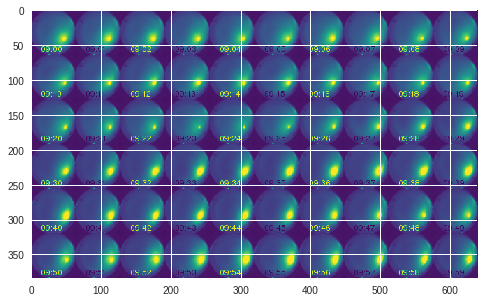

In [68]:
plt.imshow(img)

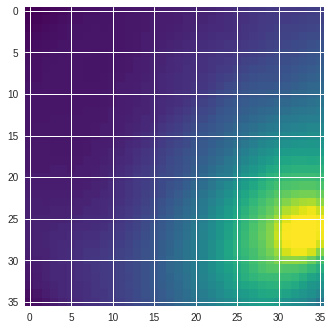

In [69]:
#One example of cropping, get the first picture (1,1)
plt.imshow(crop(img,1,1))

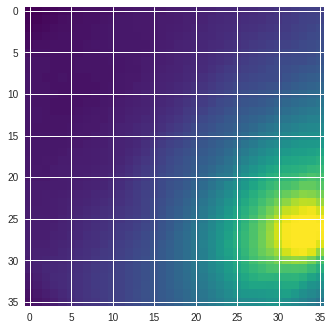

In [70]:
#Another example of cropping, get the first picture (1,2)
plt.imshow(crop(img,1,2))

# **Magnometer Components and ASI Dataset**

In [0]:
def normalize(x):
  return(x-np.min(x))/(np.max(x)-np.min(x))

In [11]:
import numpy as np
import pandas as pd
import os
mypath1 = "./gmag_clean/"
mypath2 = "./gdrive/My Drive/THEMIS/CLEAN_2010/clean/"

year = np.array(['{:02d}'.format(i) for i in range(4,19)])
month = np.array(['{:02d}'.format(i) for i in range(1,13)])
day = np.array(['{:02d}'.format(i) for i in range(1,32)])
minutes = np.array(['{:02d}'.format(i) for i in range(60)])
hour = np.array(['{:02d}'.format(i) for i in range(24)])
st = 'TPAS'
data = pd.DataFrame({})
Pixels_mean = np.array([])
ye = '10'
for mo in month :
  for da in day :
     for ho in hour :
        for mi in minutes :
            filename1 = mypath1+"20"+ye+"/"+mo+"/"+da+"/"+st+ye+mo+da+"_MAG_"+ho+"_"+mi+".HKD"
            filename2 = mypath2+st.lower()+'.20'+ye+'.'+mo+'.'+da+'.'+'ut'+ho+'.pgm'
            if ((os.path.exists(filename1)) and (os.path.exists(filename2))): 
                #DATA SET OF MAGNOMETER VALUES
                df = pd.read_csv(filename1, delim_whitespace = True)
                df = df.drop(['ETemp','STemp','GTemp','GPS'], axis=1)
                data = data.append(df, ignore_index=True)
                #ALL SKY IMAGES (MEAN OF PIXELS)
                img = 255-cv2.imread(filename2,0)
                for i in range(6):
                  for j in range(10):
                    new_img = normalize(crop(img,i,j))
                    mean_img = np.mean(new_img)
                    Pixels_mean = np.append(Pixels_mean,mean_img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


## **Correlation between the magnetic field and the aurora observations ** 


In this paragraph we will explain that the magnetic field might be helpful for forecasting auroras, consider 
$$
B(t)=(b_1(t),b_2(t),b_3(t))
$$
the component of the magnetic field over time $t$. The cell before gives the vector $B(t)$ over periods of one year $2010$. Let's use diffrent plots in our analysis, first we plot $\left\|(b_1(t),b_2(t))\right\|=\sqrt{b^2_1(t)+b^2_2(t)}$  against time $t$ to get

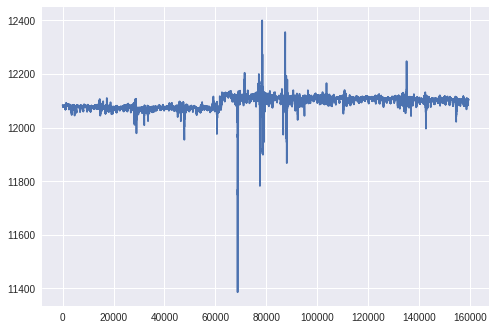

In [78]:
plt.plot(np.sqrt(data.CH1**2+data.CH2**2))

We can see from the last plot that, the tangent vector to the ground  $(b_1(t),b_2(t))$ is almost constant except for some point where we have a huge change in the norm of the vector which is caused maybe by a substroms. We can't quite say that there is an Aurora merely by knowing the tangent vector to the ground! Let's look now at the plot of $b_3(t)$ over time,

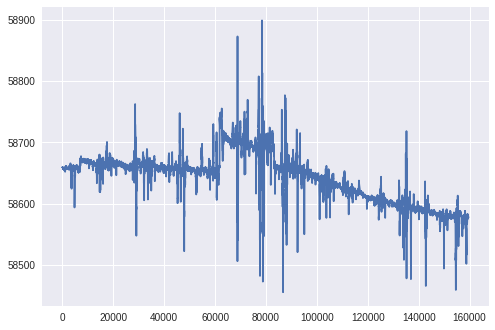

In [79]:
plt.plot(data.CH3)

the analysis of the compenent $b_3$, we note that this is the largest compenent among all, and the more lickely one to cause an aurora. 
Note that $b_3$ is mosetely influced by sular winds that cause geomagnetic storms, which is one of the causes of the auroral phenomenon. But now, let's look at intensity of the vector $B(t)$.

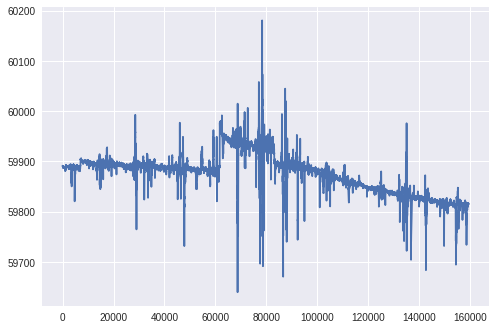

In [80]:
plt.plot(np.sqrt(data.CH1**2+data.CH2**2+data.CH3**2))

Notice that the plot of the vector $B(t)$ is very close in shape to the one of the component $b_3$, as we explained before $b_3$ is the most dominant compenent. 

Using only the previous shapes can not give information about the correlation between the observations and the magnetic field. Therefore, it is good to look the derivative of the magnetic field $dB/dt$ as well as the variation of the images in the ASI file. We use the following method to draw the derivative of $B(t)$:

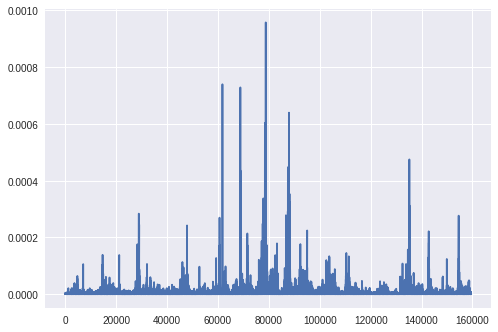

In [76]:
DATA = normalize(np.asarray(data.loc[:,['CH1','CH2','CH3']]))
plt.plot(np.abs(np.gradient(np.sqrt(DATA[:,0]**2+DATA[:,1]**2+DATA[:,2]**2))))

*Note* : Normalizing data is important in order to do comparison between plots!

Since we have a huge dataset of images (one picture each minutes for one year!), and we want to minimize compute time,  after normalizing the pixels in images, we will reduce each one to a one pixel (the mean of pixels in the image -- see the python cell above). Then we calculate the variation of brightness $dP/dt$ where $P$ is the mean pexil of each image. We get the following plot

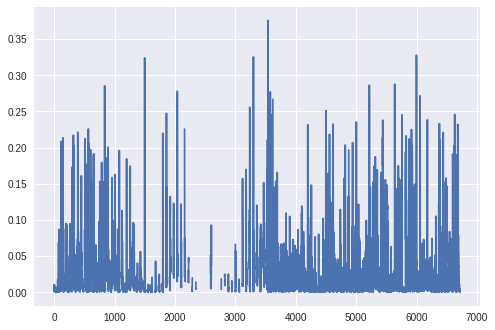

In [81]:
plt.plot(np.abs(np.gradient(Pixels_mean)))

One can see that the two last plots are quite correlated (even though the lenght of time series are diffrent-- due to lack of time, we did not figure out how to solve that problem!). And we can therefore conclude that the magnetic field can be a cause of an auroral phenomenon. We tried for diffrent values values when the magnetic field was large, and we found a results that matches with an aurora in the ASI dataset.

## **Forecasting northern lights using convolutional neural networks**

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision


In [0]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
import numpy as np
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 36, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [0]:
model = ConvNet()
img2 = np.expand_dims(crop(img), axis = 0)
img2 = np.expand_dims(img2.transpose(), axis = 0)
img2.transpose().shape
model(torch.autograd.Variable(torch.from_numpy(img2)))